<h3>Machine Learning for Diffusion</h3>

This notebook was developed in order to train autoencoder models to study anomalous diffusion with unsupervised learning. This repo supports creating/loading existing autoencoder models and the necessary data sets to train them. Here we will go through an example of how to use this part of the repository.

We will generate diffusion trajectories using code from the github repository AnDi challenge by Gorka Muñoz-Gil. With AnDi it is possible to generate trajectories in 1D, 2D and 3D from the following diffusion models: annealed transit time model (**ATTM**), continuous time random walks (**CTRW**), fractional brownian motion (**FBM**), Lévy walks (**LW**) and scaled brownian motion (**SBM**). **In this notebook we will only work with trajectories in 1D**. For more information about AnDi go to https://github.com/AnDiChallenge/ANDI_datasets.

<h3>Create/Load ANDI dataset</h3>

First, we need to import AnDi and all the necessary libraries to generate the trajectores.

In [1]:
import numpy as np
import andi

We start by generating an andi object

In [2]:
ANDI = andi.andi_datasets()

andi has a built-in method that displays the anomalous diffusion models available:

In [3]:
ANDI.avail_models_name

['attm', 'ctrw', 'fbm', 'lw', 'sbm']

Now we need to specify the parameters that will be used to generate the trajectories. Here ***timesteps*** defines the length of the trajectories, ***N_trainset*** the size (number of trajectories) of the training set and ***N_testset*** the size of the test set. ***exponents*** defines the anomalous exponent of the trajectories, and its value is a list containing the values of the desired anomalous exponents. ***diffusion_models*** is a list with values ranging from 0 to 4 that represent the desired diffusion models in the order ['attm', 'ctrw', 'fmb', 'lw', 'sbm'], so 0 for attm, 1 for ctrw, 2 for fbm, 3 for lw and 4 for sbm. Given *T, N*, *exponents* and *trajectories*, ANDI generates N trajectories of length T per exponent and per model. 

In [4]:
timesteps = 20     # Number of steps per trajectory
N_trainset = 100     # Number of trajectories in the training set per model & per exponent
exponents = [0.7,0.8,0.9,1]     # Anomalous exponent. Creates a dataset of size N_trajectories * T_trajectory for each exponent
diffusion_models = [0,1]     # Models. In order: ['attm', 'ctrw', 'fbm', 'lw', 'sbm']

In this example we generate 100 trajectories of length 20 for the exponents 0.7, 0.8, 0.9 and 1 for attm and ctrw, so 800 trajectories in total for the training set.

Andi allows you to save the trajectories you create, so you don't have to create new ones every time. You can specify this when calling andi.create_dataset() by passing in as argument ***save_trajectories = True*** and the path where the trajectories will be saved. The data set can be then loaded with ***load_trajectories = True***. If load_trajectories is *False*, ANDI will generate new trajectories according to the specified parameters. This is described in more detail in https://github.com/AnDiChallenge/ANDI_datasets.

In [5]:
# Creating training set
train_dataset = ANDI.create_dataset(T = timesteps, N = N_trainset, exponents = exponents, models = diffusion_models,
                              load_trajectories = False, dimension = 1)

ANDI.create_dataset() returns a numpy array with size (N * number of exponents * number of models, T + 2). We can check the shape of both the training set:

In [6]:
print(train_dataset.shape)

(800, 22)


We can see that our train set consists of 800 trajectories of length 22.
The first two values of each trajectory correspond to the model and exponent of the trajectory, respectively:

In [7]:
print(train_dataset[0][:2])

[0.  0.7]


This trajectory is generated from the 'attm' model and its anomalous exponent is 0.7. The remaining values are the position vector of the 1D trajectory:

In [8]:
print(train_dataset[0][2:])

[ 0.         -1.07399391 -1.80438918 -1.3082489  -0.74774806 -2.27505375
 -2.28150919 -2.57484887 -0.9897417   1.01349976  0.16484938  2.11303549
  1.71077916  1.1179244   1.57101736  3.52872669  3.23228306  3.94653736
  3.8891276   4.15016731]


Since these values (model and exponent) are not needed for training and they affect the true value of the trajectories, they are removed when we prepare the data set. This means that we are left with trajectories of length 20.

**Prepare Data set**

In [9]:
import torch
from utils import prepare_dataset

Here we use the PyTorch library to work with deep neural networks. Pytorch supports GPU-accelerated tensor computing with CUDA. Before defining the model that we will train we need to convert the trajectories from numpy arrays to torch tensors. We do this by importing the function **prepare_dataset** from *utils*. This function normalizes the trajectories, shuffles them and converts them to pytorch tensors (also accepts shuffle=*False*). The function also takes into account that the first two values are for the model and the exponent, respectively. If **return_labels=*True***, the labels are returned in addition to the trajectories.

It is recommended to use a GPU when training the network. Device specifies the usage of either CPU or GPU. If a GPU is available, set gpu = *True* to use it. The tensors are converted with the PyTorch function **.to()**:

In [10]:
gpu = True 
device = torch.device('cuda' if gpu and torch.cuda.is_available() else 'cpu')   # Select GPU if available

In [11]:
# Normalize, shuffle trajectories and convert them to pytorch tensors
trainset = prepare_dataset(train_dataset)

If we check the shape of our new tensors we can see that the length and shape of the trajectories has been fixed:

In [12]:
print(trainset.shape)

torch.Size([800, 1, 20])


<h3>Define the autoencoder model</h3>

To define the autoencoder we start by importing the libraries that will be used to load or create the model

In [13]:
import autoencoder
import torch.nn as nn
from torch.utils.data import DataLoader

We also need to define the hyperparameters that will be used for training. Here we set the number of epochs, batch size, learning rate and weight decay.

In [14]:
epochs = 30     # Training epochs
batch_size =  30    # Batch size
learning_rate = 1e-3     # Learning rate
weight_decay = 1e-4     # Weight decay

**Data Loader**

We use the PyTorch's **DataLoader** function to combine the dataset with a sampler that provides an iterable over the dataset. Here we pass in as arguments the batch size, a boolean called *shuffle* and the number of workers. If shuffle = *True*, the data reshuffles after each iteration (or epoch during training). The number of workers determines how many processes are used for data loading. If num_workers = 0, the data will be loaded in the main process. See https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader for more information.

In [15]:
#Load data into dataloader
dataloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4)

Now it's time to define the autoencoder. All available models inherit from the parent class **Autoencoder()**, which includes functions for training, saving and loading the models. We can see the avaiable models by calling the **show_models()** function from *autoencoder*.

In [16]:
autoencoder.show_models()

['Final_Skip_Connections', 'Small']


The only mandatory argument needed to create an autoencoder is the size of the input data, in this case the length of the 1D trajectories. Additionally, the size of the latent space can be passed in as argument when the autoencoder is created, although all the models have a pre-difined size for their latent space. Other arguments accepted by some of the models include the number of channels at the output of the encoder, the output size of the global average pooling layer or a boolean called *decode*, which defines whether the output is that of the encoder or that of the decoder (this is discussed more in detail at the end of this notebook). In this example we will create an autoencoder from the class Small:

In [17]:
# Here timesteps should be the length of the trajectories. We load the model to the GPU with to(device)
model = autoencoder.Small(timesteps).to(device)

We can see the number of parameters in the network by calling **model.get_number_of_parameters()**

In [18]:
model.get_number_of_parameters()

63365

PyTorch allows us to see the architecture of the network by calling **model.parameters**:

In [19]:
model.parameters

<bound method Module.parameters of Small(
  (conv1): Conv1d(1, 16, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv2): Conv1d(16, 16, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv3): Conv1d(16, 32, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv4): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv5): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv6): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (global_pool): AdaptiveAvgPool1d(output_size=1)
  (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=4, bias=True)
  (fc3): 

To change one of the layers of the encoder we can use the Pytorch class **torch.nn**, here imported as **nn**:

```Python 
model.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2)
model.maxpool = nn.MaxPool1d(kernel_size=2, stride=2)
model.fc1 = nn.Linear(320,32)
etc.
```

To change a convolutional tranpose or a max unpooling layer in the decoder you can use the set_ConvTranspose1d() or set_MaxUnpool1d() function from **Autoencoder**. As arguments you need to pass in the input dimensions and output dimensions of the layer, as well as the layer parameters (channels, kernel size, stride and padding).

```Python
model.set_ConvTranspose1d(input_size=50, output_size=50, in_channels=32, out_channels=16, kernel_size=3)
model.set_MaxUnpool1d(input_size=50, output_size=25, kernel_size=2, stride=2)
```

In general we don't want to modify the structure of the already defined models other than occasionally changing the size of the latent space. It is preferred to add new models or modify them directly in *autoencoder.py*

<h3>Train the model</h3>

Before training the model we need to define a loss function and choose our optimizer. In this case we are using Mean Squared Error (MSE) as loss and Adam as optimizer. Check PyTorch's master documentation (https://pytorch.org/docs/stable/nn.html) to see the supported loss functions and optimizers.

In [20]:
loss = nn.MSELoss()     # Define loss function
optimizer = torch.optim.Adam(model.parameters(),weight_decay=weight_decay,lr=learning_rate)     # Choose optimizer (Adam)

To train the model simply call **model.train_model** and pass in the required parameters: *epochs*, *dataloader*, *loss*, *optimizer* and *device*. The function also accepts a data loader for the validation set, which is not required. If we do want to use a validation set, we can pass the validation data loader as the last parameter *val_loader*. Here we will create and use a validation set to see how the training of the model evolves with increasing number of epochs. train_model will print a notifying message when the training process is complete.

In [21]:
# Generate validation set
N_valset = 20
val_set = ANDI.create_dataset(T = timesteps, N = N_valset, exponents = exponents, models = diffusion_models)
validation_set = prepare_dataset(val_set)
validation_loader = DataLoader(validation_set, batch_size=batch_size, shuffle=False, num_workers=0)

In [22]:
model.train_model(epochs, dataloader, loss, optimizer, device, validation_loader)


epoch [5/30], training loss:1.4477, validation loss:1.4489
epoch [10/30], training loss:1.0260, validation loss:1.2630
epoch [15/30], training loss:0.9896, validation loss:1.0307
epoch [20/30], training loss:0.8172, validation loss:0.9974
epoch [25/30], training loss:0.7715, validation loss:1.1987
epoch [30/30], training loss:0.8327, validation loss:0.9825
model training completed


<h3>Save the model</h3>

To save the model it is recommended to include all the hyperparameters and other relevant parameters in a dictionary. **model.save_model** accepts two arguments: an ordered dictionary with the names and values of any relevant parameters that may be considered worth saving and the name that will be given to the trained model. **save_model** saves the length of the trajectories, the number of epochs, the dictionary with the parameters, the trained model and the loss per epoch (both for the training and validation sets) in a dictionary in disk.

In [23]:
parameters = {
    'batch size': batch_size,
    'learning rate': learning_rate,
    'weight decay': weight_decay,
    'optimizer': 'Adam',
    'optimizer state dict': optimizer.state_dict(),
    'exponents': exponents,
    'diffusion models': [(0, 'attm'), (1, 'ctrw')],
    'training dataset size': N_trainset,
    'loss function': 'Mean Squared Error (MSE)'
}

If we want to save the model and continue training it latter, we need to save the state of the optimizer in the dictionary with optimizer.state_dict(). It is important that if we want to save the state of the optimizer, its key name in the dictionary is exactly 'optimizer state dict'. This is useful for latter visualizing the parameters that we saved. Here we save the test model in the example models folder.

In [24]:
path = 'models/'
model_name = 'example_model'
save_name = path + model_name

In [25]:
model.save_model(parameters, save_name)

model saved


<h3> Load saved model </h3>

To load a model we first need to create an autoencoder object  with the same architecture as the model we want to load. In case we forgot the autoencoder model or the size of the latent space, we can use the function **autoencoder.get_model**, which prints them and returns the size of the trajectories, the size after average pooling and the size of the latent space in a list:

In [26]:
# path & name of the file with the trained model
path = 'models/'
name = 'example_model'
load_name = path + name
# this prints the autoencoder model, the size of the trajectories used for training and the size of the latent space
autoencoder.get_model(load_name)

autoencoder model: Small
length of the trajectories: 20
size of the latent space: 4
size average pooling: 1


[20, 4, 1]

Now we can create our autoencoder object and load our model with **model.load_model**:

In [27]:
model = autoencoder.Small(20)
model.load_model(load_name)

model loaded


The function *load_model* automatically loads the weights of the trained model to our *model* object. When a model is loaded, the autoencoder object automatically gets an attribute model.state_dict, which contains the dictionary with all the hyperparameters and specifications that we saved when we trained our model. To see them (excluding the state of the model with the trained parameters and the array with the loss per epoch, which may occupy too much space on screen) we can call the function **model.show_model_properties**:

In [28]:
model.show_model_properties()

Training hyperparameters & diffusion models specifications:
average pooling size: 1
length trajectories: 20
weight decay: 0.0001
learning rate: 0.001
batch size: 30
latent space: 4
loss function: Mean Squared Error (MSE)
exponents: [0.7, 0.8, 0.9, 1]
optimizer: Adam
epochs: 30
diffusion models: [(0, 'attm'), (1, 'ctrw')]
autoencoder class: Small
training dataset size: 100
minimum training loss: 0.6034275837242603
minumum validation loss: 0.855322603136301
best epoch (validation set): 29


If we want to continue training a model, we need to load the state of the optimizer at the time the model was saved. To do this, we define an optimizer of the same class (example: optimizer = torch.optim.Adam(* *args*)) and we load the optimizer with **optimizer.load_state_dict(*'saved optimizer'*)**. If we saved the state of the optimizer when we saved the model, we can access it through model.model_dict['optimizer state dict']. For more information about saving and loading models in PyTorch visit https://pytorch.org/tutorials/beginner/saving_loading_models.html. 

In [29]:
#define the optimizer
optimizer = torch.optim.Adam(model.parameters(),weight_decay=1e-4,lr=1e-3)
#load the optimizer state dict
optimizer.load_state_dict(model.model_dict['optimizer state dict'])

The number of epochs is accumulative, meaning that if we saved a model that was trained for 30 epochs, and then we load it and train it again for 30 more epochs, the total number of epochs will be 60.

We can also see the loss per epoch during training in logarithmic scale by calling **model.plot_loss**. By default, it plots the loss per epoch over the training set. We can set the parameter *split='validation'* to see the loss per epoch in the validation set. We can also pass the argument log_scale = *False* to obtain linear plot.

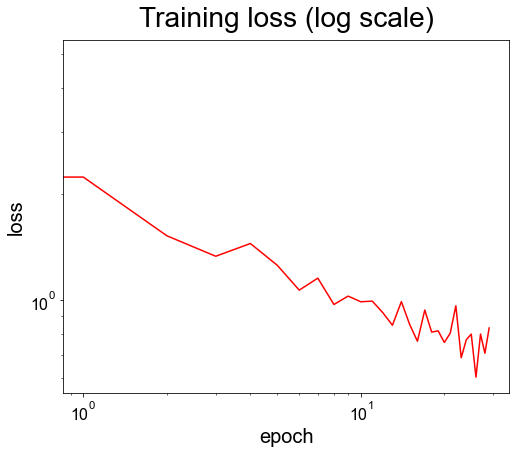

In [30]:
model.plot_loss()

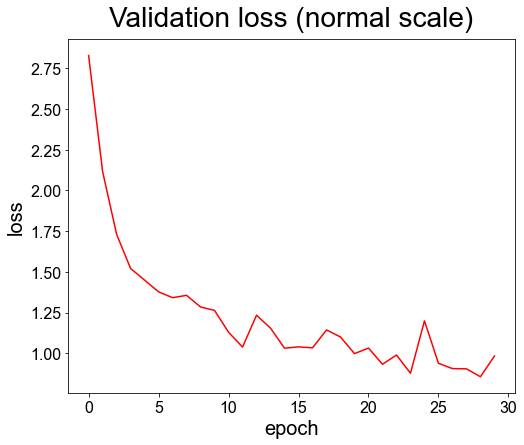

In [31]:
model.plot_loss(logscale=False, split='validation')

*Note: according to pytorch documentation, it is necessary run model.eval() to set dropout and batch normalization layers to evaluation mode before running inference, otherwise the results will be inconsistent. According to my experience this turns out to be the exact opposite, as running model.eval() would cause problems in models with dropout or batch normalization. Here by default I don't use model.eval() and I don't recommend using it if your model has any dropout or batch normalization layers.*

Now that we have our trained model loaded we can test it with examples from the test set.

<h3>Inference with test set</h3>

In [32]:
from utils import do_inference, normalize
from matplotlib import rc
import matplotlib.pyplot as plt
rc('font',**{'family':'sans-serif','sans-serif':['Arial']})

We will now create our test set and check how well our autoencoder does. The length of the trajectories must be the same that was used to train the model. Here we will test a trained model from the *Final_Skip_Connections* class, trained with trajectories with anomalous exponent = 0.6 for attm, ctrw, fbm & sbm trajectories.

In [33]:
autoencoder.get_model('models/FSC_0.6')

autoencoder model: Final_Skip_Connections
length of the trajectories: 200
size of the latent space: 20
size average pooling: 4


[200, 20, 4]

In [34]:
model = autoencoder.Final_Skip_Connections(200, latent_space=20)
model.load_model('models/FSC_0.6')

model loaded


In [35]:
model.show_model_properties()

Training hyperparameters & diffusion models specifications:
average pooling size: 4
length trajectories: 200
weight decay: 1e-05
learning rate: 0.001
batch size: 256
latent space: 20
loss function: Mean Squared Error (MSE)
exponents: 0.6
optimizer: Adam
epochs: 200
diffusion models: [(0, 'attm'), (1, 'ctrw'), (2, 'fbm'), (4, 'sbm')]
autoencoder class: Final_Skip_Connections
training dataset size: 32000
minimum training loss: 0.359930721282959


For models with batch normalization, inference must be done with at least as many trajetories as the batch size that was used to train the model, even if we only want to visualize the results with a small fraction of the data set. Otherwise the results may be faulty. In this case we can see that the batch size that was used to train the model is 256, so we need to generate at least 256 trajectories.

In [36]:
timesteps = 200     
N_testset = 64     
exponents = 0.8
diffusion_models = [0,1,2,4]
load_trajectories = False

ANDI = andi.andi_datasets()
test_dataset = ANDI.create_dataset(T = timesteps, N = N_testset, exponents = exponents, models = diffusion_models,
                              load_trajectories = load_trajectories, N_save = 4000, t_save = 2000, dimension = 1,
                              path = "andi datasets/test datasets/")

#prepare tets data set for inference
testset = prepare_dataset(test_dataset, shuffle=False)

In [37]:
testset.shape

torch.Size([256, 1, 200])

Now we do inference with the test set:

In [38]:
autoencoder_result = do_inference(testset, model)

The following plots show the output of the autoencoder (orange) given an input trajectory (blue). Here we plot examples of attm, ctrw, fbm & sbm trajectories.

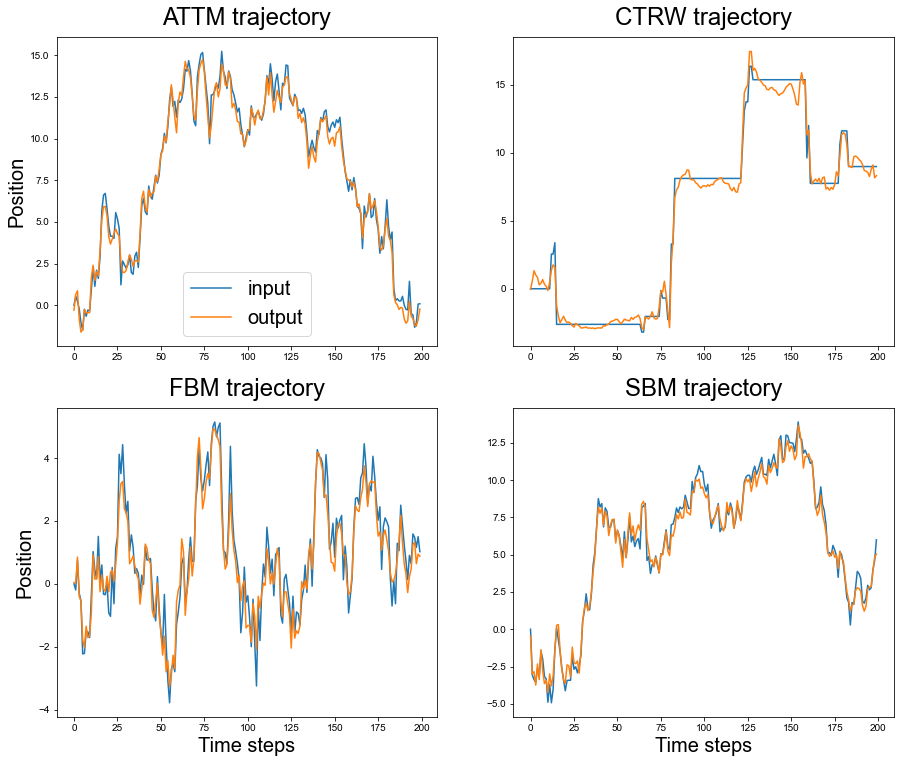

In [39]:
# show inference with test example
fig, ax = plt.subplots(2,2,figsize=(15,12.5))
for i in range(4):
    ax[int(i/2),i-2*int(i/2)].set_title(ANDI.avail_models_name[i+int(i/3)].upper() + ' trajectory', fontsize=24, y=1.02)
    ax[int(i/2),i-2*int(i/2)].plot(normalize(test_dataset[i*64,2:])[0], label='input')
    ax[int(i/2),i-2*int(i/2)].plot(autoencoder_result[i*64], label='output')
    ax[int(i/2),0].set_ylabel('Position', fontsize=20)
    ax[1,int(i/2)].set_xlabel('Time steps', fontsize=20)
ax[0,0].legend(fontsize=20)
#plt.savefig('trajectories diffusion models')

<h3>Encode or Decode</h3>

The model has an attribute called *decode*, which can be set to *True* or *False*. By default it is set to *True*, so that we see the output of the decoder which is a reconstruction of the input. If model.decode = *False*, the output is that of the latent space. This is useful when studying the distribution of trajectories in a lower dimensional space, which can then be visualized using 2D UMAP, PCA or other dimensionality reduction methods.